* [https://www.kaggle.com/olgabelitskaya/flower-color-images](https://www.kaggle.com/olgabelitskaya/flower-color-images)



* VGG16学習済みモデルによる転移学習
    * VGG16
        * ILSVRCデータセット
        * ILSVRC: 物体識別コンペティション
        * 1000クラス
        * 入力データのサイズ: (batch, channel:3, height:224, width:224)
        * channelの順序: (Blue, Green, Red) （PIL default RGB）
        * 各チャネルから（学習データの）平均値を引く。VGG16の場合は (B:103.939, G:116.779, R:123.68)

In [1]:
import time
import glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
matplotlib.style.use('ggplot')
from sklearn.manifold import TSNE
import chainer
from chainer import Chain, optimizers, training
from chainer.training import extensions
import chainer.functions as F
import chainer.links as L
from PIL import Image
from tqdm import tqdm

In [2]:
images_path = './flower_images/*.png'

In [3]:
 #!wget http://www.robots.ox.ac.uk/~vgg/software/very_deep/caffe/VGG_ILSVRC_16_layers.caffemodel

In [4]:
caffemodel = './VGG_ILSVRC_16_layers.caffemodel'
chainermodel = './VGG_ILSVRC_16_layers.npz'

# L.VGG16Layers.convert_caffemodel_to_npz(caffemodel, chainermodel)

In [5]:
# !ls
!dir

 ドライブ C のボリューム ラベルは Windows です
 ボリューム シリアル番号は EE3F-F695 です

 C:\Users\B0063sugimori\01 Chainer Transfer Learning\Flower_Color_Images のディレクトリ

2018/07/18  16:44    <DIR>          .
2018/07/18  16:44    <DIR>          ..
2018/07/18  12:08    <DIR>          .ipynb_checkpoints
2018/07/18  12:33             3,064 Chainerで転移学習・特徴量抽出して類似度を測ってみた ? データ分析.._.lnk
2017/10/31  20:33        41,291,504 FlowerColorImages.h5
2018/07/18  11:22    <DIR>          flower_images
2018/07/18  16:44         3,208,647 TransferLearningVGG16.ipynb
2018/07/18  12:08         3,406,967 TransferLearningVGG16_org.ipynb
2018/07/18  10:44       553,432,081 VGG_ILSVRC_16_layers.caffemodel
2018/07/18  11:40       553,437,510 VGG_ILSVRC_16_layers.npz
               6 個のファイル       1,154,779,773 バイト
               4 個のディレクトリ  57,190,408,192 バイトの空き領域


In [6]:
vgg = L.VGG16Layers(chainermodel)
# vgg = chainer.links.VGG16Layers(chainermodel)

In [7]:
vgg._children

{'conv1_1',
 'conv1_2',
 'conv2_1',
 'conv2_2',
 'conv3_1',
 'conv3_2',
 'conv3_3',
 'conv4_1',
 'conv4_2',
 'conv4_3',
 'conv5_1',
 'conv5_2',
 'conv5_3',
 'fc6',
 'fc7',
 'fc8'}

In [8]:
paths, features = [], []
for path in tqdm(glob.glob(images_path)):
    
    paths.append(path)
    
    img = Image.open(path)
    if img.mode != 'RGB':
        img = img.convert('RGB')

    feature = vgg.extract([img], layers=['fc7'])['fc7']
    feature = feature.data.reshape(-1)
    features.append(feature)

100%|████████████████████████████████████████████████████████████████████████████████| 210/210 [04:25<00:00,  1.27s/it]


In [9]:
def cos_sim_matrix(matrix):
    d = matrix @ matrix.T
    norm = (matrix * matrix).sum(axis=1, keepdims=True) ** .5
    return d / norm / norm.T

features = np.array(features)
cos_sims = cos_sim_matrix(features)

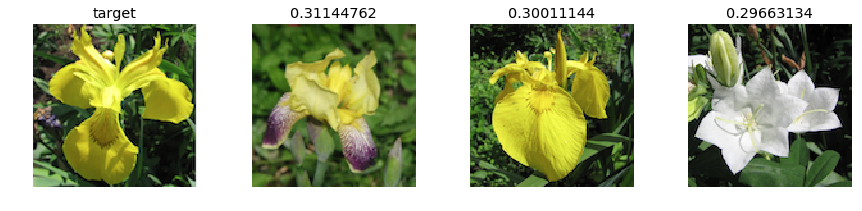

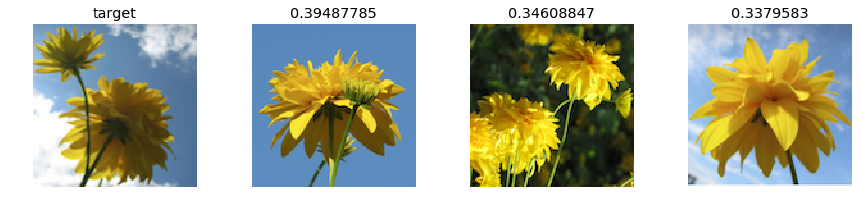

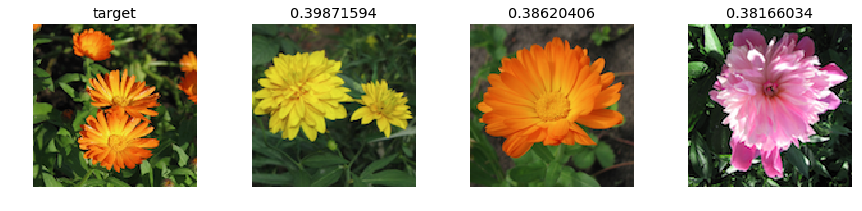

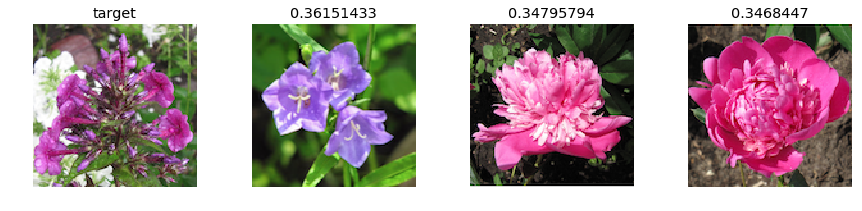

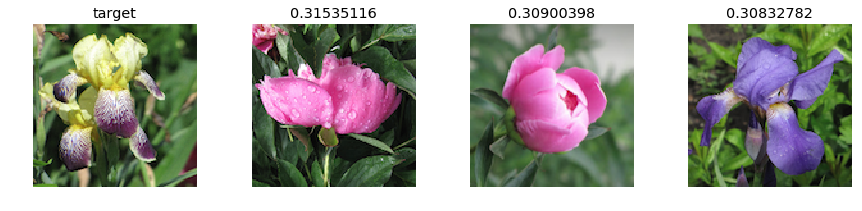

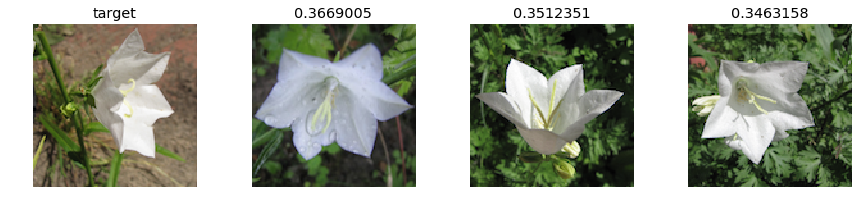

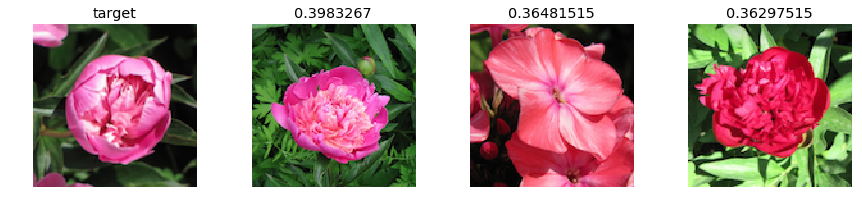

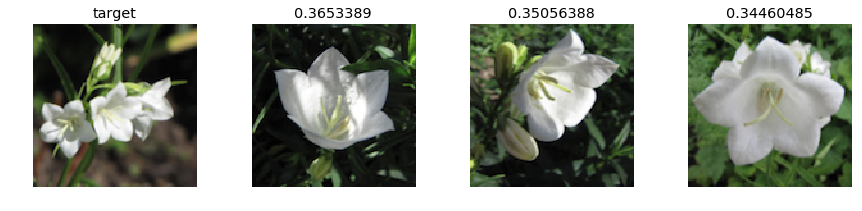

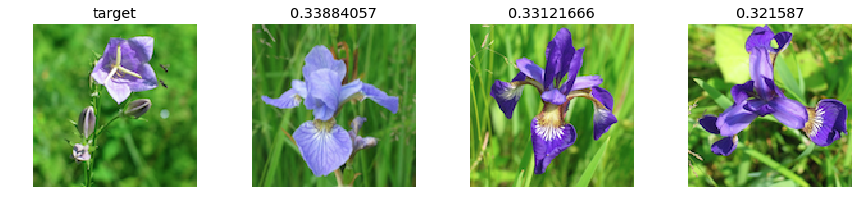

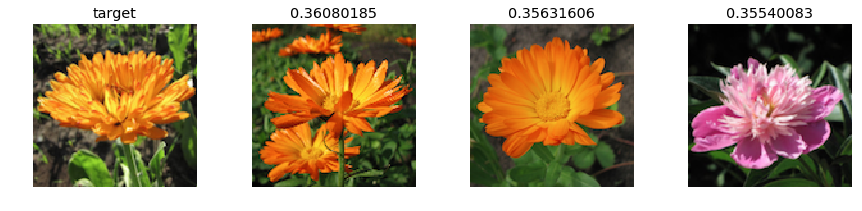

In [10]:
samples = np.random.randint(0, len(paths), 10)
for i in samples:
    sim_idxs = np.argsort(cos_sims[i])[::-1]
    sim_idxs = np.delete(sim_idxs, np.where(sim_idxs==i))
    
    sim_num = 3
    sim_idxs = sim_idxs[:sim_num]
    fig, axs = plt.subplots(ncols=sim_num+1, figsize=(15, sim_num))
    img = Image.open(paths[i])
    axs[0].imshow(img)
    axs[0].set_title('target')
    axs[0].axis('off')
    
    for j in range(sim_num):
        img = Image.open(paths[sim_idxs[j]])
        axs[j+1].imshow(img)
        axs[j+1].set_title(cos_sims[i, sim_idxs[j]])
        axs[j+1].axis('off')
        
    plt.show()

In [11]:
tsne_model = TSNE(n_components=2).fit_transform(features)

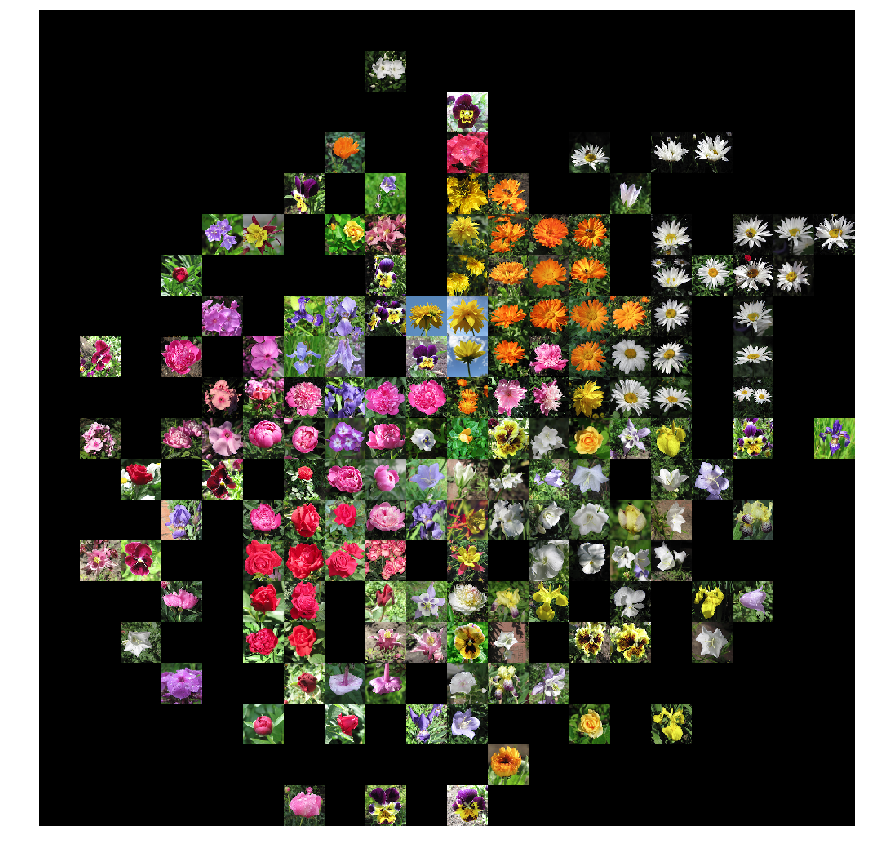

In [12]:
canvas_size = (1000, 1000)
img_size = (50, 50)
canvas = Image.new('RGB', canvas_size)

val_max = np.array(tsne_model).max()
val_min = np.array(tsne_model).min()

for i, path in enumerate(paths):
    pos_x = int(tsne_model[i][0]*(canvas_size[0]/img_size[0])/(val_max-val_min))*img_size[0]
    pos_y = int(tsne_model[i][1]*(canvas_size[1]/img_size[1])/(val_max-val_min))*img_size[1]
    pos = (int(pos_x+canvas_size[0]/2), int(pos_y+canvas_size[1]/2))
    target_img = Image.open(path)
    target_img = target_img.resize(img_size)
    canvas.paste(target_img, pos)
    target_img.close()
    
plt.figure(figsize=(15,15))
plt.imshow(np.array(canvas))
plt.axis('off')
plt.show() 